In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn import svm, linear_model, datasets, neighbors
import random
from sklearn.neural_network import MLPClassifier
import sklearn.ensemble as ske
%matplotlib inline

In [2]:
#importing test and train data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

df = df_train.copy()
df = df.drop(['Survived'], axis = 1)

#training dataset contains 891 samples
#combining both the datasets together for similar transformations
df = df.append(df_test)
df = df.reset_index(drop=True)

In [3]:
#Feature Engineering: (did it in Excel earlier, moving it here)
#step_1: Get prefixes from the Name. Categorize the prefixes
#step_2: Fill in missing Age values by the category medians
#step_3: Fill in the missing Embarked values with the most frequent
#step_4: Fill in missing Fare value with the average
#step_5: replacing the missing values in Cabin with X
#step_6: getting Pclass in shape

In [4]:
#step_1: Get prefixes from the Name. Categorize the prefixes
df['Prefix'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
df = df.replace(['Don', 'Dona', 'Jonkheer', 'Lady', 'Sir', 'the Countess'],"HighBorn")
df = df.replace(['Capt', 'Col','Dr', 'Major', 'Rev'],'Army')
df = df.replace(['Dr', 'Major', 'Rev'],'Army')
df = df.replace(['Mlle'],'Miss')
df = df.replace(['Mme', 'Ms'],'Mrs')

dummy = pd.get_dummies(df['Prefix'],prefix='Prefix')
df = pd.concat([df,dummy],axis=1)
df = df.drop(['Name'], axis = 1)

In [5]:
#step_2: Fill in missing Age values by the category averages
grouped_data = df.groupby(['Sex','Pclass','Prefix'])
grouped_data = grouped_data.median()

#missing_age_values = np.where(pd.isnull(df['Age']))

#replacing the missing values with the category(Sex, Pclass, Prefix) averages
for i in range(0,df.shape[0]):
    if(pd.isnull(df['Age'][i])):
        age = grouped_data.loc[df['Sex'][i], df['Pclass'][i], df['Prefix'][i]]['Age']
        df.set_value(i,'Age', age)
        
df['Sex'] = df['Sex'].map({'male':1,'female':0})
df = df.drop(['Prefix'], axis = 1)

In [6]:
#step_3: Fill in missing Embarked value
df['Embarked'] = df['Embarked'].fillna('S')
dummy = pd.get_dummies(df['Embarked'],prefix='Embarked')
df = pd.concat([df,dummy],axis=1)
df = df.drop(['Embarked'], axis = 1)

In [7]:
#step_4: Fill in missing Fare value
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

In [8]:
#step_5: replacing the missing values in Cabin with X
df['Cabin'] = df['Cabin'].fillna('X')
df['Cabin'] = df['Cabin'].map(lambda c : c[0])
dummy = pd.get_dummies(df['Cabin'],prefix='Cabin')
df = pd.concat([df,dummy],axis=1)
df = df.drop(['Cabin'], axis = 1)

In [9]:
#step_6: getting Pclass in shape
dummy = pd.get_dummies(df['Pclass'],prefix='Pclass')
df = pd.concat([df,dummy],axis=1)
df = df.drop(['Pclass'], axis = 1)

In [10]:
#step7: extracting the cabin/section feature from the Ticket
df['Ticket'] = df['Ticket'].str.replace('/','')
df['Ticket'] = df['Ticket'].str.replace('.','')

#for i in range(0,df.shape[0]):
    #ticket = df['Ticket'][i]
df['Ticket'] = df['Ticket'].map(lambda ticket:ticket.split(' ')[0].strip())

for i in range(0,df.shape[0]):
    ticket = df['Ticket'][i]
    if ticket.isnumeric():
        df.set_value(i,'Ticket', 'X')
    else: 
        df.set_value(i,'Ticket', ticket)

df['Ticket'] = df['Ticket'].fillna('X')

dummy = pd.get_dummies(df['Ticket'],prefix='Ticket')
df = pd.concat([df,dummy],axis=1)
df = df.drop(['Ticket'], axis = 1)


df_copy = df.copy()

In [11]:
#step8: processing the family variable, creating new categories based on the size of the family
df['FamilySize'] = df['SibSp']+ df['Parch']+1
df['Single'] = 0
df['SmallFamily'] = 0
df['LargeFamily'] = 0

df['Single'].loc[1>=df['FamilySize']] = 1
df['SmallFamily'].loc[df['FamilySize']==2] = 1
df['SmallFamily'].loc[df['FamilySize']==3] = 1
df['SmallFamily'].loc[df['FamilySize']==4] = 1
df['LargeFamily'].loc[df['FamilySize'] > 4] = 1

df = df.drop(['PassengerId'], axis = 1)

/Users/rahulmallapur/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
#separating the train and test datasets
df_train = df[:891]
df_test = df[891:]
dummy = pd.read_csv("data/train.csv")
df_train['Survived'] = dummy['Survived']

#shuffling the data to remove bias
#df_train = df_train.sample(frac=1).reset_index(drop=True)

x = df_train
x = x.drop(['Survived'], axis=1)
y = df_train['Survived']

x_test = df_test

/Users/rahulmallapur/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


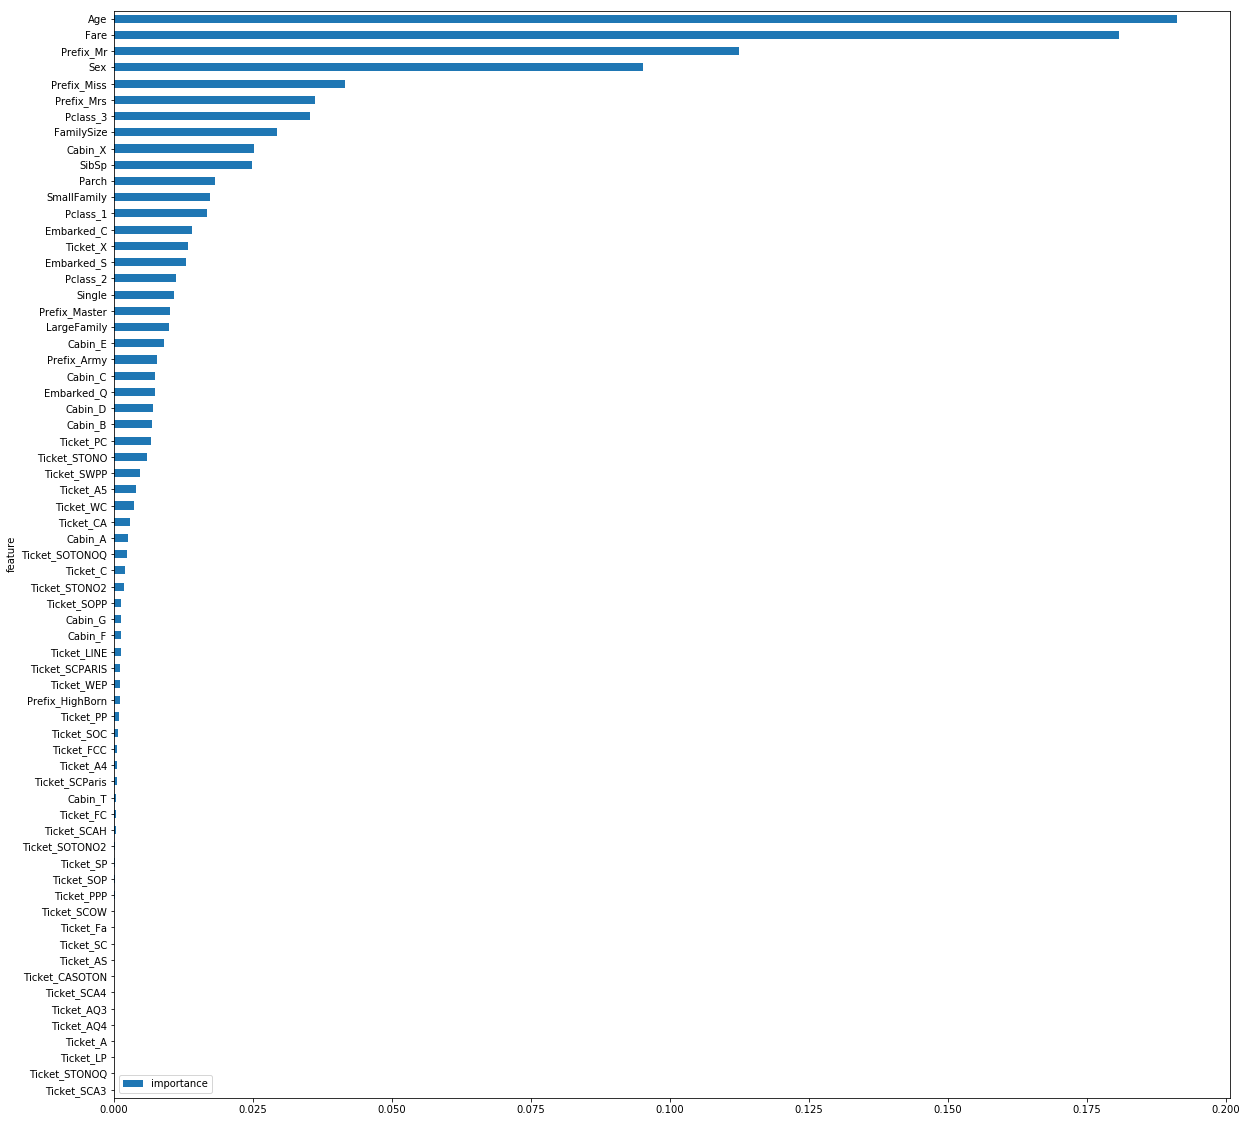

In [14]:
#Using random forest classifier to create feature importances,
#That will be used for feature selection 

clf = ske.RandomForestClassifier(n_estimators = 100)
clf = clf.fit(x, y)

features = pd.DataFrame()
features['feature'] = x.columns
features['importance'] = clf.feature_importances_

features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(20, 20))

In [16]:
#selecting the important features, using clf from above for SelectFromModel
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(clf, prefit=True)
x_reduced = model.transform(x)

x_test_reduced = model.transform(x_test)

In [19]:
#hyperparameters tuning for random forest
from sklearn.model_selection import GridSearchCV, train_test_split

#splitting the data into train and validataion
#x_train, y_train, x_valid, y_valid = train_test_split(x_train_reduced, y, test_size = 0.1)

#vary the following parameters
parameters = {'max_depth' : [4, 6, 8, 10],
              'n_estimators': [100, 50, 10, 5],
              'max_features': ['sqrt', 'auto', 'log2'],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 3, 5],
              'bootstrap': [True, False]}

solver = ske.RandomForestClassifier()

scores = 'accuracy'

models = GridSearchCV(solver, scoring = scores, param_grid = parameters)

models.fit(x, y)

print('Best score: {}'.format(models.best_score_))
print('Best parameters: {}'.format(models.best_params_))

Best score: 0.8383838383838383
Best parameters: {'bootstrap': False, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


In [18]:
final_model = models
parameters = models.best_params_

df_output = pd.DataFrame()
dummy = pd.read_csv('data/test.csv')
df_output['PassengerId'] = dummy['PassengerId']
df_output['Survived'] = final_model.predict(x_test).astype(int)
df_output[['PassengerId','Survived']].to_csv('data/output.csv',index=False)

In [21]:
x.head()

,Sex,Age,SibSp,Parch,Fare,Prefix_Army,Prefix_HighBorn,Prefix_Master,Prefix_Miss,Prefix_Mr,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,FamilySize,Single,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,0,0,1,...,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,0,0,...,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,0,0,1,0,...,1,0,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,0,0,...,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,0,0,1,...,0,0,0,0,0,1,1,1,0,0
